In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install koreanize-matplotlib

import koreanize_matplotlib
%matplotlib inline

In [7]:
import pandas as pd
import numpy as np

onlinesales_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Onlinesales_info.csv')
marketing_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Marketing_info.csv')
tax_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Tax_info.csv')
customer_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Customer_info.csv')
discount_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Discount_info.csv')

shoppingcart_df = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/shoppingcart_df.csv', index_col=0)
customer_buyinginfo_df = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/customer_buyinginfo_df.csv', index_col=0)

In [5]:
# 2019년 말일 기준으로 최근 거래일을 일로 환산하기
import datetime

today = datetime.date(2019, 12, 31)

In [8]:
rfm_df = customer_buyinginfo_df[['고객ID', '최근거래날짜', '구매횟수', '총결제금액']].copy()
rfm_df['최근거래날짜'] = [(today - datetime.date.fromisoformat(i)).days + 1 for i in customer_buyinginfo_df['최근거래날짜']]    # +1일
rfm_df.columns = ['CustomerID', 'R', 'F', 'M']
rfm_df

,CustomerID,R,F,M
0,USER_0000,108,1,99.98
1,USER_0001,60,31,15308.13
2,USER_0002,74,8,1573.49
3,USER_0003,18,11,1421.96
4,USER_0004,108,13,1524.42
...,...,...,...,...
1463,USER_1463,271,3,676.73
1464,USER_1464,88,19,2606.18
1465,USER_1465,195,2,127.90
1466,USER_1466,70,1,333.80


# 1. KMeans

In [9]:
result_df = pd.merge(customer_info, customer_buyinginfo_df, on='고객ID', how='inner')
result_df

,고객ID,성별,고객지역,가입기간,가입날짜,최초거래날짜,최근거래날짜,구매횟수,구매제품수,구매원가,할인가,배송료,총결제금액,평균결제금액,평균할인차액,평균할인비율,구매제품평균금액
0,USER_1358,남,Chicago,12,2019-01-01,2019-01-01,2019-01-26,177,1133,38520.24,37377.56,1749.28,39126.84,221.06,-6.46,0.03,32.99
1,USER_0190,남,California,43,2016-04-19,2019-01-01,2019-12-18,26,175,3360.52,3032.86,200.46,3233.32,124.36,-12.60,0.10,17.33
2,USER_0066,남,Chicago,33,2017-01-31,2019-01-01,2019-08-02,15,155,2671.90,2563.56,195.70,2759.26,183.95,-7.22,0.04,16.54
3,USER_0345,여,California,30,2017-05-23,2019-01-01,2019-01-01,1,1,1.46,1.46,6.50,7.96,7.96,0.00,0.00,1.46
4,USER_0683,남,California,49,2015-12-01,2019-01-01,2019-08-30,6,15,1150.17,903.36,64.38,967.74,161.29,-41.14,0.26,60.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_0513,여,New York,41,2016-07-05,2019-12-30,2019-12-31,5,29,559.89,491.44,31.50,522.94,104.59,-13.69,0.13,16.95
1464,USER_0167,여,Chicago,48,2016-01-05,2019-12-31,2019-12-31,14,35,3272.39,3150.20,103.99,3254.19,232.44,-8.73,0.04,90.01
1465,USER_0845,남,New Jersey,19,2018-04-17,2019-12-31,2019-12-31,3,10,810.39,803.39,19.50,822.89,274.30,-2.33,0.01,80.34
1466,USER_0504,여,New York,45,2016-02-02,2019-12-31,2019-12-31,6,11,1198.59,1131.15,39.00,1170.15,195.02,-11.24,0.06,102.83


## 1-1. 이상치 미처리

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

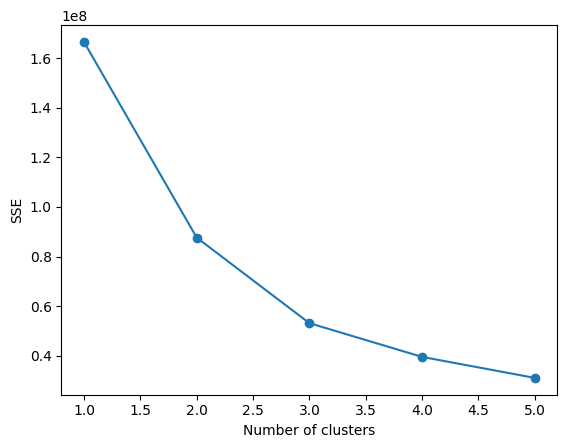

In [ ]:
# 엘보우 방법을 사용하여 최적의 K값 탐색
sse = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, random_state=13)
    kmeans.fit(result_df[['구매횟수', '구매제품수', '평균결제금액']])
    sse.append(kmeans.inertia_)

# SSE 그래프 그리기
plt.plot(range(1, 6), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

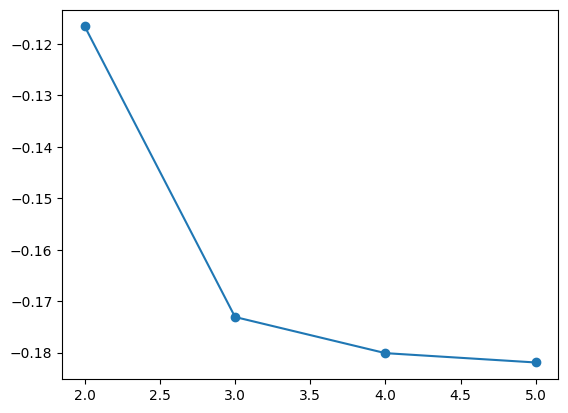

In [ ]:
# 실루엣 분석을 사용하여 최적의 K값 탐색
silhouette_scores = []
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(result_df[['구매횟수', '구매제품수', '평균결제금액']])
    score = silhouette_score(customer_buyinginfo_df[['구매횟수', '구매제품수', '평균결제금액']], kmeans.labels_)
    silhouette_scores.append(score)

# 실루엣 분석 그래프 그리기
plt.plot(range(2, 6), silhouette_scores, marker='o');

- --> 4개로 클러스터링 진행

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def kmeans_draw_3d_plot(df, col1, col2, col3, num):

  # 군집화 변수 선택 및 kmeans, 데이터프레임
  feature = df[[col1, col2, col3]]
  model = KMeans(n_clusters=num, n_init='auto', random_state=13)
  model.fit(feature)

  predict = pd.DataFrame(model.labels_, columns=['cluster'])
  tmp_df = pd.concat([df, predict], axis=1)

  print(tmp_df.groupby(['cluster'])[col1, col2, col3].mean())
  print('-'*100)
  print(tmp_df[['cluster']].value_counts())
  print('='*100)

  plt.figure(figsize=(15, 15))
  ax = plt.axes(projection='3d')
  ax.scatter3D(tmp_df['구매횟수'], tmp_df['구매제품수'], tmp_df['평균결제금액'], c=tmp_df['cluster'], s=100)
  ax.set_xlabel('구매횟수')
  ax.set_ylabel('구매제품수')
  ax.set_zlabel('평균결제금액')
  ax.view_init(elev=25, azim=-55)
  plt.show()

  return tmp_df, tmp_df[[col1, col2, col3, 'cluster']]


               구매횟수        구매제품수      평균결제금액
cluster                                     
0         31.028777   328.431655  252.093058
1        194.375000  2967.375000  412.188750
2         59.307692   948.215385  256.471385
3         11.275739    54.929275  156.967628
----------------------------------------------------------------------------------------------------
cluster
3          1117
0           278
2            65
1             8
dtype: int64


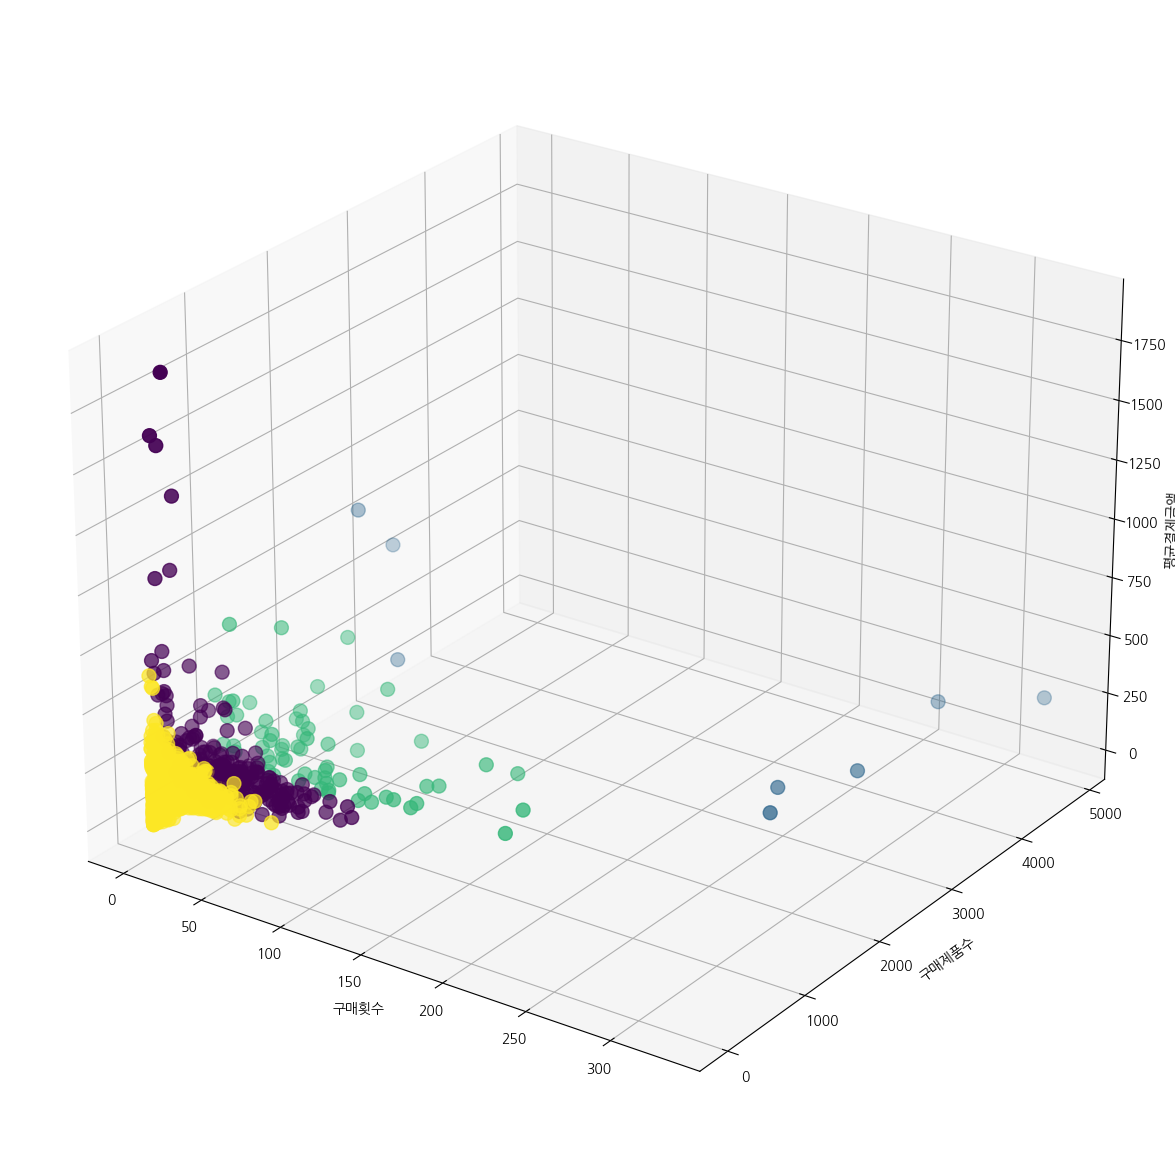

In [ ]:
total_df, kmeans_cols_df = kmeans_draw_3d_plot(result_df, '구매횟수','구매제품수', '평균결제금액', 4)

- 클러스터별 평균치 계산

In [ ]:
total_df.groupby(['cluster'])[['가입기간', '구매횟수', '구매제품수', '평균결제금액']].mean()

,가입기간,구매횟수,구매제품수,평균결제금액
cluster,,,,
0,26.374101,31.028777,328.431655,252.093058
1,32.750000,194.375000,2967.375000,412.188750
2,25.476923,59.307692,948.215385,256.471385
3,25.773500,11.275739,54.929275,156.967628


- 두 변수간 그래프 확인

In [ ]:
def drawScatterplot(df, col1, col2):

  sns.scatterplot(data = df, x = col1, y = col2, hue = 'cluster');

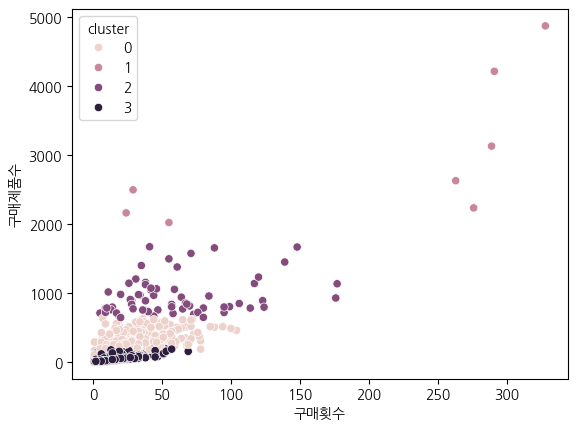

In [ ]:
drawScatterplot(total_df, '구매횟수', '구매제품수')

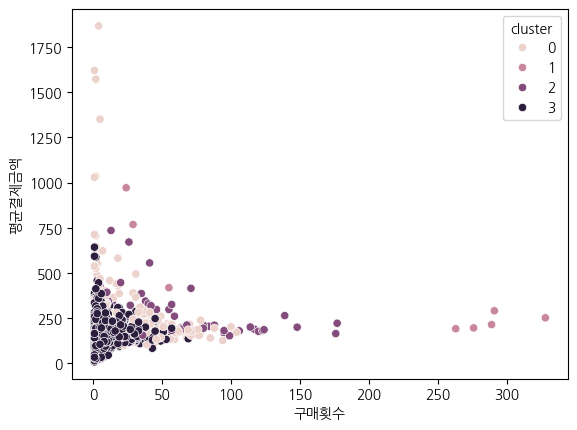

In [ ]:
drawScatterplot(total_df, '구매횟수', '평균결제금액')

- --> 구매횟수와 평균결제금액 사이에는 구분이 그리 명확하지 않아보임

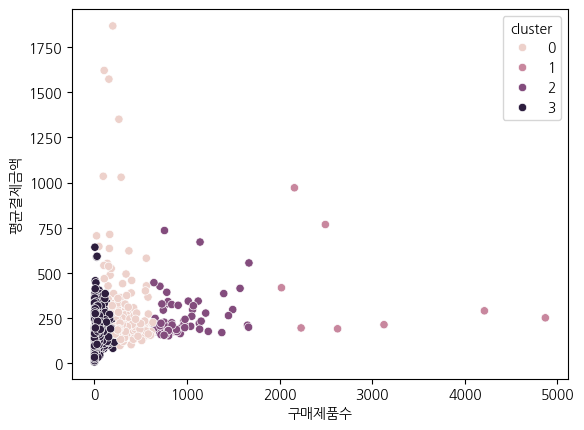

In [ ]:
drawScatterplot(total_df, '구매제품수', '평균결제금액')

In [ ]:
kmeans_cols_df

,구매횟수,구매제품수,평균결제금액,cluster
0,177,1133,221.06,2
1,26,175,124.36,3
2,15,155,183.95,3
3,1,1,7.96,3
4,6,15,161.29,3
...,...,...,...,...
1463,5,29,104.59,3
1464,14,35,232.44,3
1465,3,10,274.30,3
1466,6,11,195.02,3


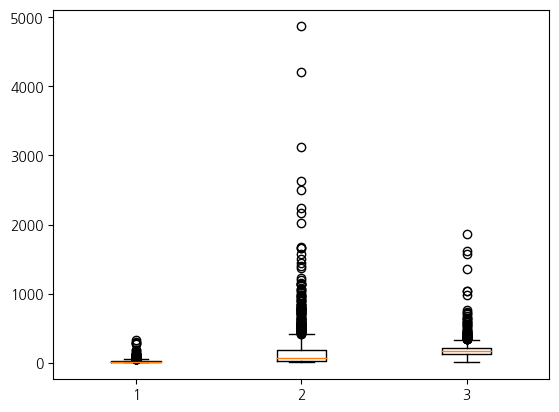

In [ ]:
fig, ax = plt.subplots()

ax.boxplot([kmeans_cols_df['구매횟수'], kmeans_cols_df['구매제품수'], kmeans_cols_df['평균결제금액']]);

## 1-2. scaler 적용

### 1-2-1. standard scaler

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols_standard = scaler.fit_transform(result_df[['구매횟수', '구매제품수', '평균결제금액']])
cols_df_standard = pd.DataFrame(cols_standard, columns = ['구매횟수', '구매제품수', '평균결제금액'])

In [ ]:
cols_df_standard

,구매횟수,구매제품수,평균결제금액
0,6.362528,3.109038,0.325775
1,0.314764,0.041158,-0.456282
2,-0.125802,-0.022890,0.025649
3,-0.686522,-0.516057,-1.397662
4,-0.486265,-0.471223,-0.157613
...,...,...,...
1463,-0.526316,-0.426390,-0.616171
1464,-0.165853,-0.407176,0.417810
1465,-0.606419,-0.487235,0.756351
1466,-0.486265,-0.484033,0.115177


In [ ]:
def checkElbow(df):
  # 엘보우 방법을 사용하여 최적의 K값 탐색
  sse = []
  for k in range(1, 6):
      kmeans = KMeans(n_clusters=k, random_state=13)
      kmeans.fit(df[['구매횟수', '구매제품수', '평균결제금액']])
      sse.append(kmeans.inertia_)

  # SSE 그래프 그리기
  plt.plot(range(1, 6), sse, marker='o')
  plt.xlabel('Number of clusters')
  plt.ylabel('SSE')
  plt.show()


def checkSilhouette(df):
  # 실루엣 분석을 사용하여 최적의 K값 탐색
  silhouette_scores = []

  for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df[['구매횟수', '구매제품수', '평균결제금액']])
    score = silhouette_score(customer_buyinginfo_df[['구매횟수', '구매제품수', '평균결제금액']], kmeans.labels_)
    silhouette_scores.append(score)

  # 실루엣 분석 그래프 그리기
  plt.plot(range(2, 6), silhouette_scores, marker='o');

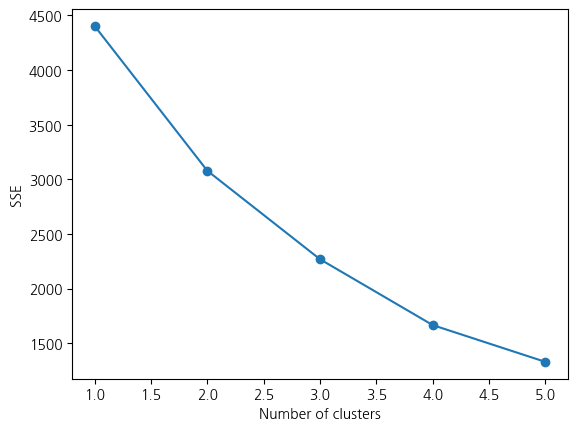

In [ ]:
checkElbow(cols_df_standard)

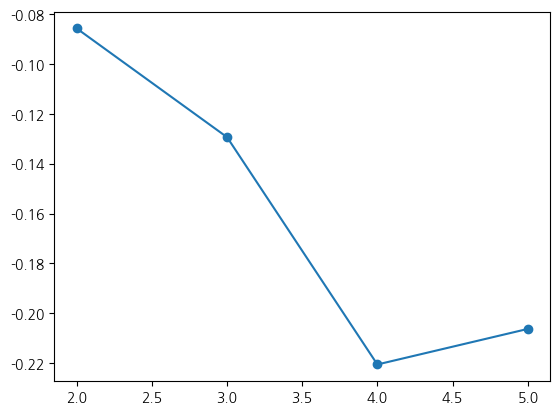

In [ ]:
checkSilhouette(cols_df_standard)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def kmeans_draw_3d_plot2(result_df, df, col1, col2, col3, num):

  # 군집화 변수 선택 및 kmeans, 데이터프레임
  feature = df
  model = KMeans(n_clusters=num, n_init='auto', random_state=13)
  model.fit(feature)

  predict = pd.DataFrame(model.labels_, columns=['cluster'])
  tmp_df = pd.concat([result_df.drop([col1, col2, col3], axis=1), predict, feature], axis=1)

  print(tmp_df.groupby(['cluster'])[col1, col2, col3].mean())
  print('-'*100)
  print(tmp_df[['cluster']].value_counts())
  print('='*100)

  plt.figure(figsize=(15, 15))
  ax = plt.axes(projection='3d')
  ax.scatter3D(tmp_df[col1], tmp_df[col2], tmp_df[col3], c=tmp_df['cluster'], s=100)
  ax.set_xlabel('구매횟수')
  ax.set_ylabel('구매제품수')
  ax.set_zlabel('평균결제금액')
  ax.view_init(elev=25, azim=-55)
  plt.show()

  return tmp_df, tmp_df[[col1, col2, col3, 'cluster']]

              구매횟수      구매제품수    평균결제금액
cluster                                
0        -0.252562  -0.272422 -0.119321
1        -0.503429   0.977625  9.455312
2        10.864307  10.410467  0.382516
3         1.278513   1.359224  0.390979
----------------------------------------------------------------------------------------------------
cluster
0          1249
3           207
1             7
2             5
dtype: int64


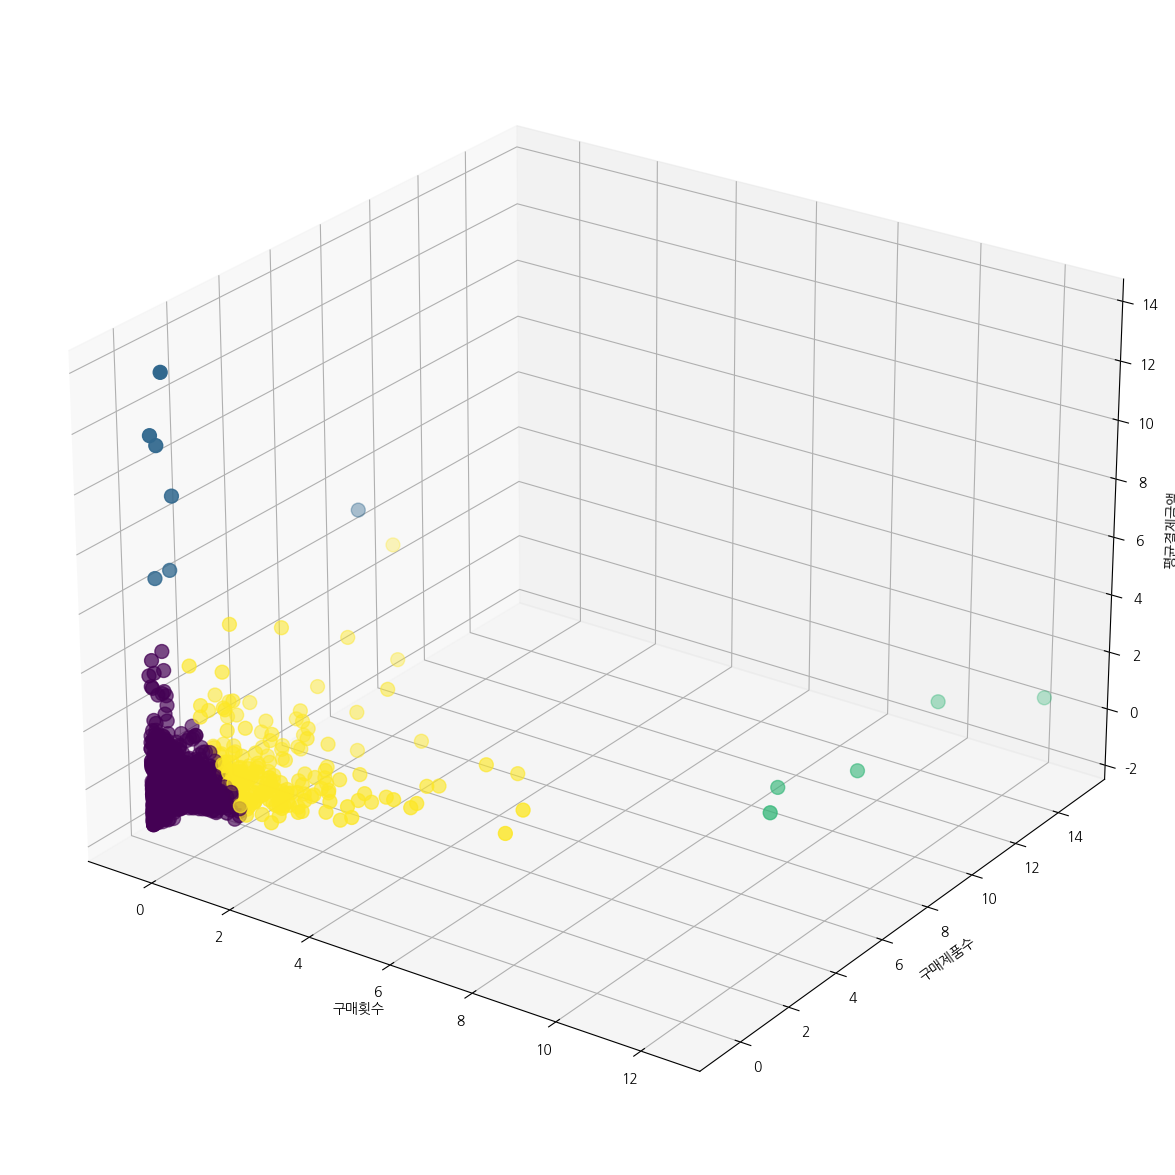

In [ ]:
total_df_standard, kmeans_cols_df_standard = kmeans_draw_3d_plot2(result_df, cols_df_standard, '구매횟수', '구매제품수', '평균결제금액', 4)

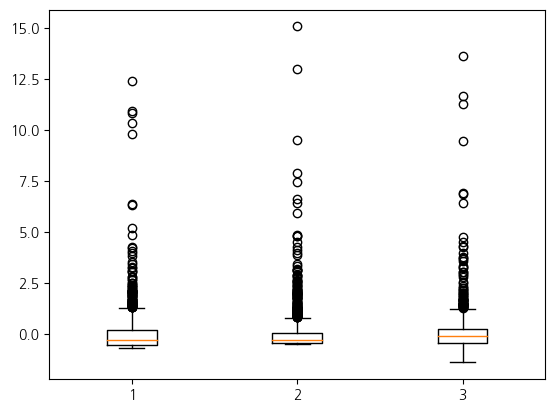

In [ ]:
fig, ax = plt.subplots()

ax.boxplot([kmeans_cols_df_standard['구매횟수'], kmeans_cols_df_standard['구매제품수'], kmeans_cols_df_standard['평균결제금액']]);

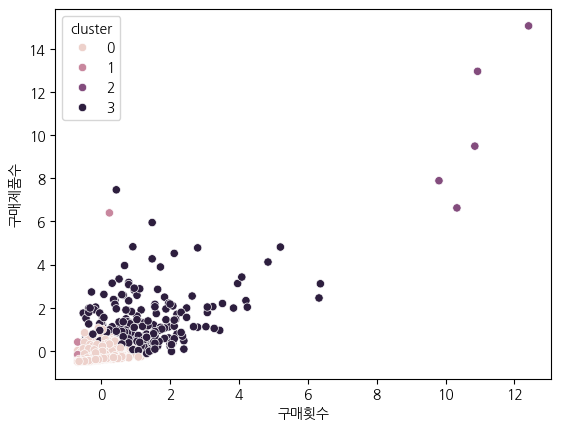

In [ ]:
drawScatterplot(total_df_standard, '구매횟수', '구매제품수')

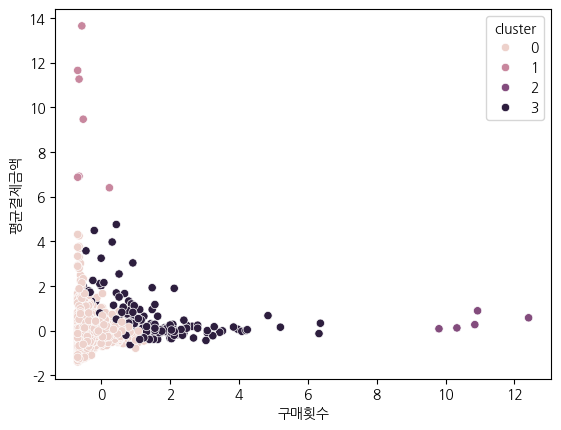

In [ ]:
drawScatterplot(total_df_standard, '구매횟수', '평균결제금액')

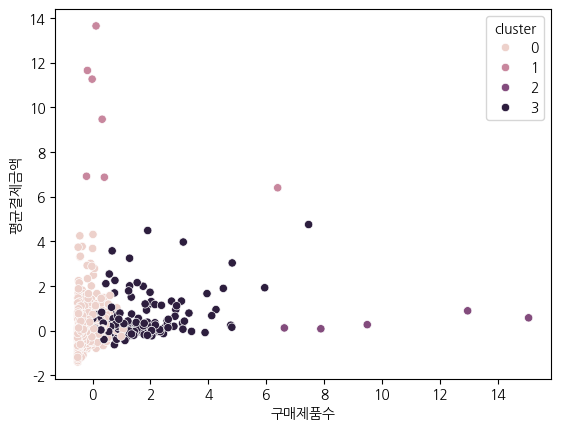

In [ ]:
drawScatterplot(total_df_standard, '구매제품수', '평균결제금액')

### 1-2-2. minmax scaler 적용

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols_minmax = scaler.fit_transform(result_df[['구매횟수', '구매제품수', '평균결제금액']])
cols_df_minmax = pd.DataFrame(cols_minmax, columns = ['구매횟수', '구매제품수', '평균결제금액'])

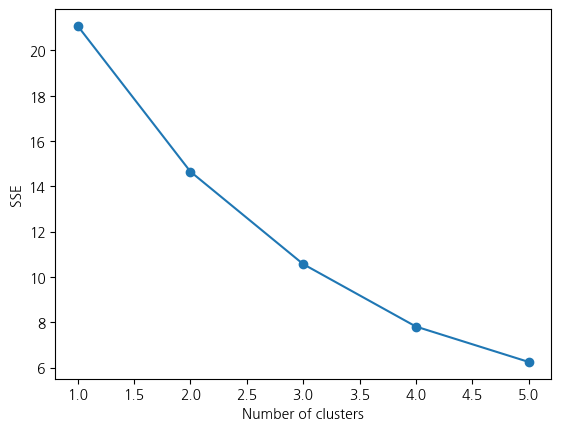

In [ ]:
checkElbow(cols_df_minmax)

             구매횟수     구매제품수    평균결제금액
cluster                              
0        0.032822  0.016523  0.086265
1        0.157338  0.119370  0.115854
2        0.881957  0.700904  0.118815
3        0.013980  0.095815  0.721706
----------------------------------------------------------------------------------------------------
cluster
0          1258
1           198
3             7
2             5
dtype: int64


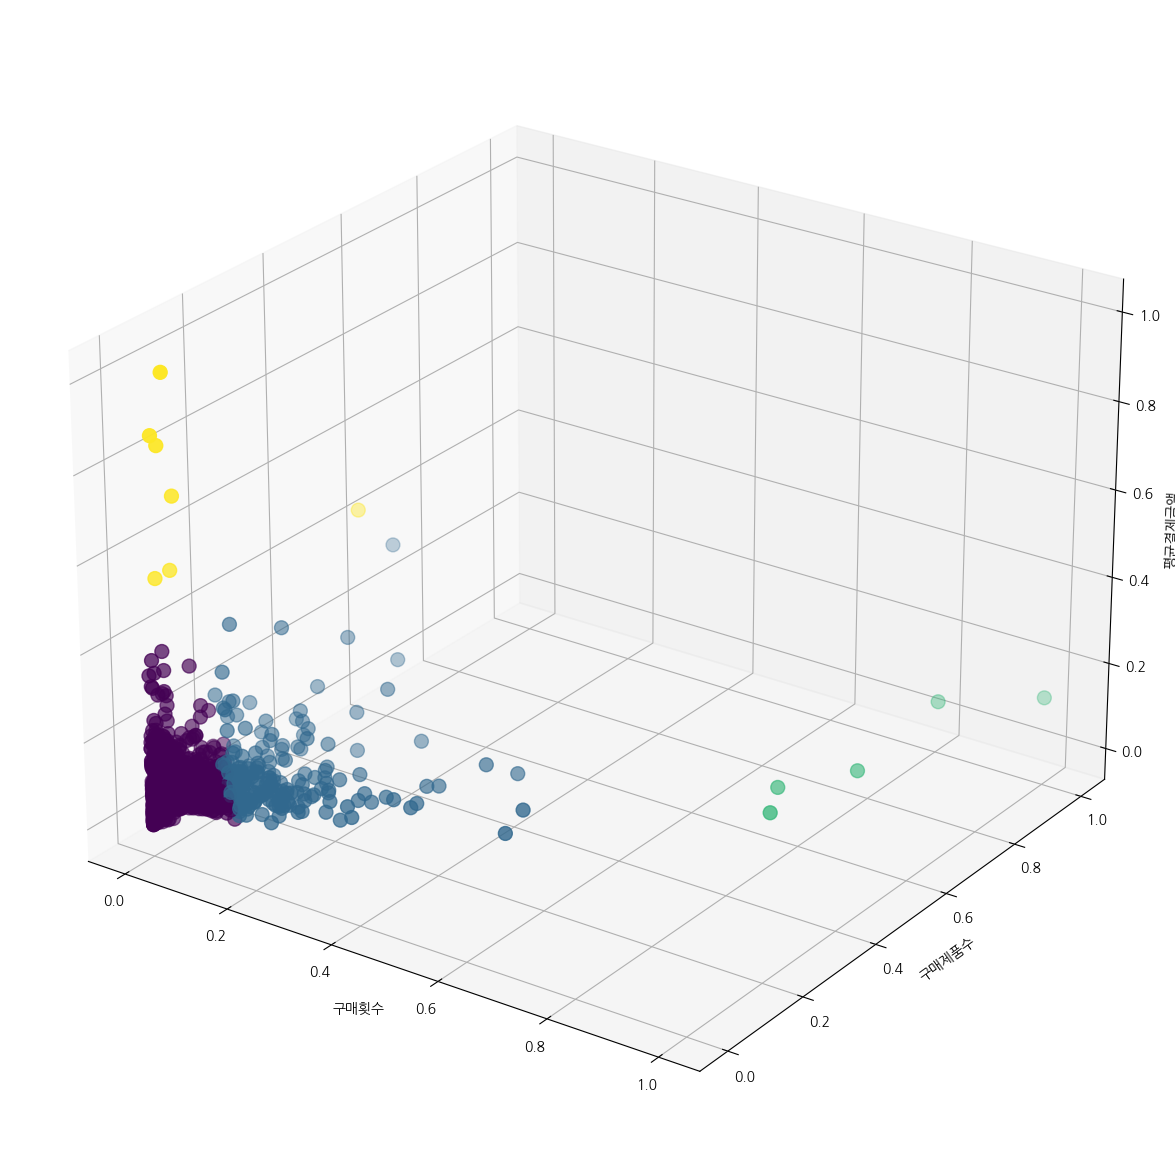

In [ ]:
total_df_minmax, kmeans_cols_df_minmax = kmeans_draw_3d_plot2(result_df, cols_df_minmax, '구매횟수', '구매제품수', '평균결제금액', 4)

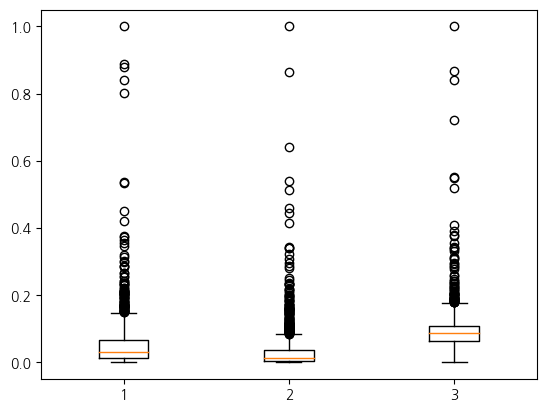

In [ ]:
fig, ax = plt.subplots()

ax.boxplot([kmeans_cols_df_minmax['구매횟수'], kmeans_cols_df_minmax['구매제품수'], kmeans_cols_df_minmax['평균결제금액']]);

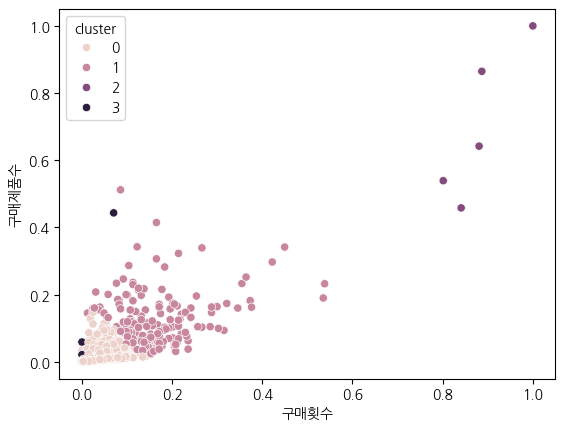

In [ ]:
drawScatterplot(total_df_minmax, '구매횟수', '구매제품수')

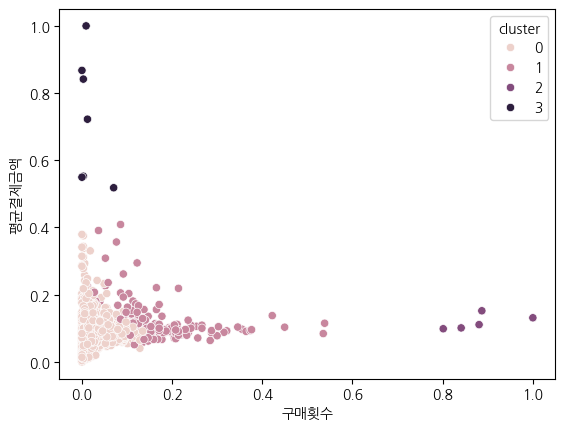

In [ ]:
drawScatterplot(total_df_minmax, '구매횟수', '평균결제금액')

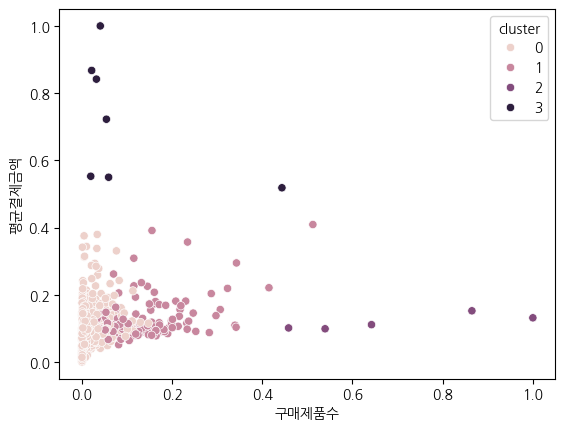

In [ ]:
drawScatterplot(total_df_minmax, '구매제품수', '평균결제금액')

### 1-2-3. robust scaler 적용

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
cols_robust = scaler.fit_transform(result_df[['구매횟수', '구매제품수', '평균결제금액']])
cols_df_robust = pd.DataFrame(cols_robust, columns = ['구매횟수', '구매제품수', '평균결제금액'])

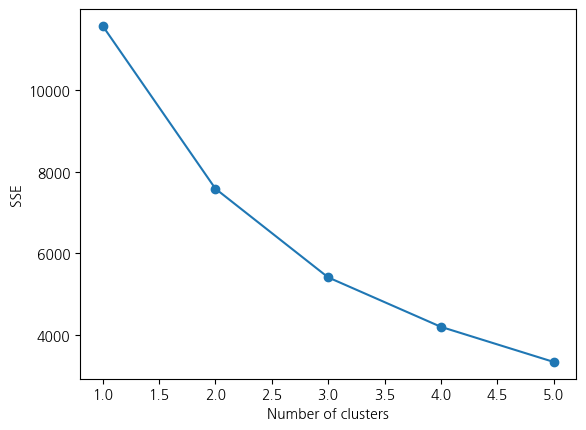

In [ ]:
checkElbow(cols_df_robust)

              구매횟수      구매제품수    평균결제금액
cluster                                
0         0.098371   0.122475 -0.061628
1        -0.305556   1.658662  8.021611
2        15.466667  21.081761  0.701271
3         2.249677   3.700856  0.654561
----------------------------------------------------------------------------------------------------
cluster
0          1269
3           172
1            22
2             5
dtype: int64


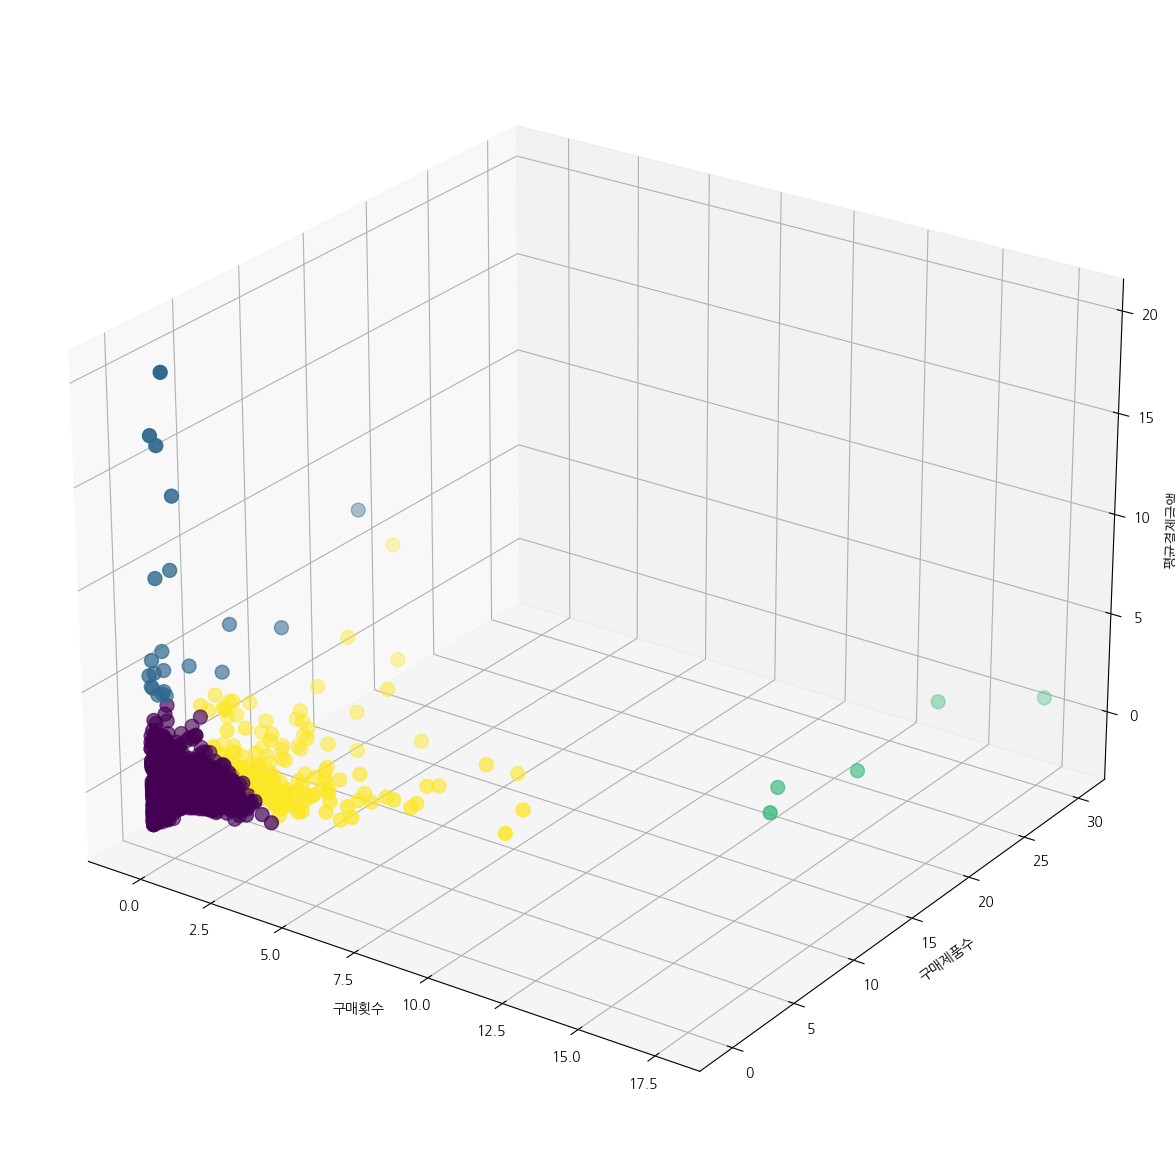

In [ ]:
total_df_robust, kmeans_cols_df_robust = kmeans_draw_3d_plot2(result_df, cols_df_robust, '구매횟수', '구매제품수', '평균결제금액', 4)

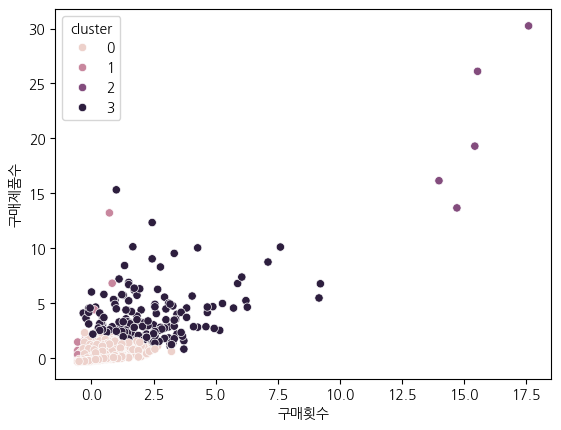

In [ ]:
drawScatterplot(total_df_robust, '구매횟수', '구매제품수')

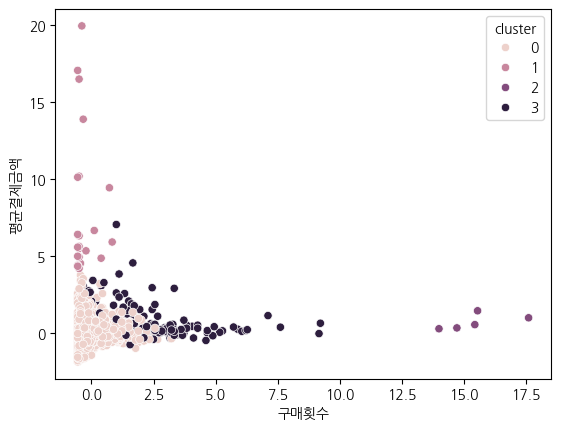

In [ ]:
drawScatterplot(total_df_robust, '구매횟수', '평균결제금액')

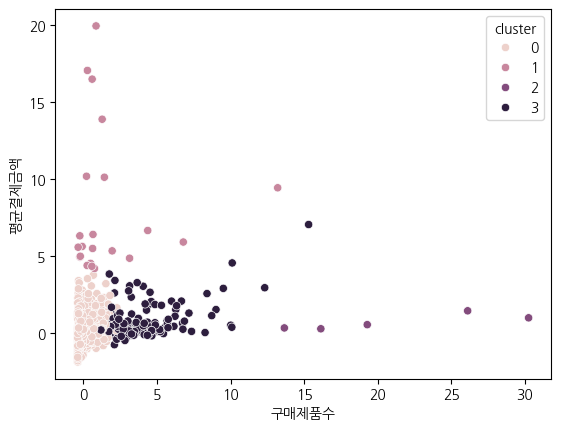

In [ ]:
drawScatterplot(total_df_robust, '구매제품수', '평균결제금액')

### 1-2-4. normalizer 적용

In [ ]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer()
cols_normalized = scaler.fit_transform(result_df[['구매횟수', '구매제품수', '평균결제금액']])
cols_df_normalized = pd.DataFrame(cols_normalized, columns = ['구매횟수', '구매제품수', '평균결제금액'])

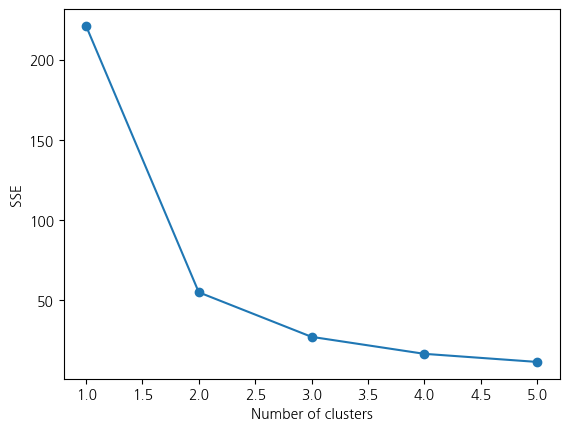

In [ ]:
checkElbow(cols_df_normalized)

             구매횟수     구매제품수    평균결제금액
cluster                              
0        0.092417  0.750789  0.643390
1        0.046497  0.136056  0.985510
2        0.082611  0.933813  0.326619
3        0.088985  0.455412  0.878019
----------------------------------------------------------------------------------------------------
cluster
1          683
3          335
0          272
2          178
dtype: int64


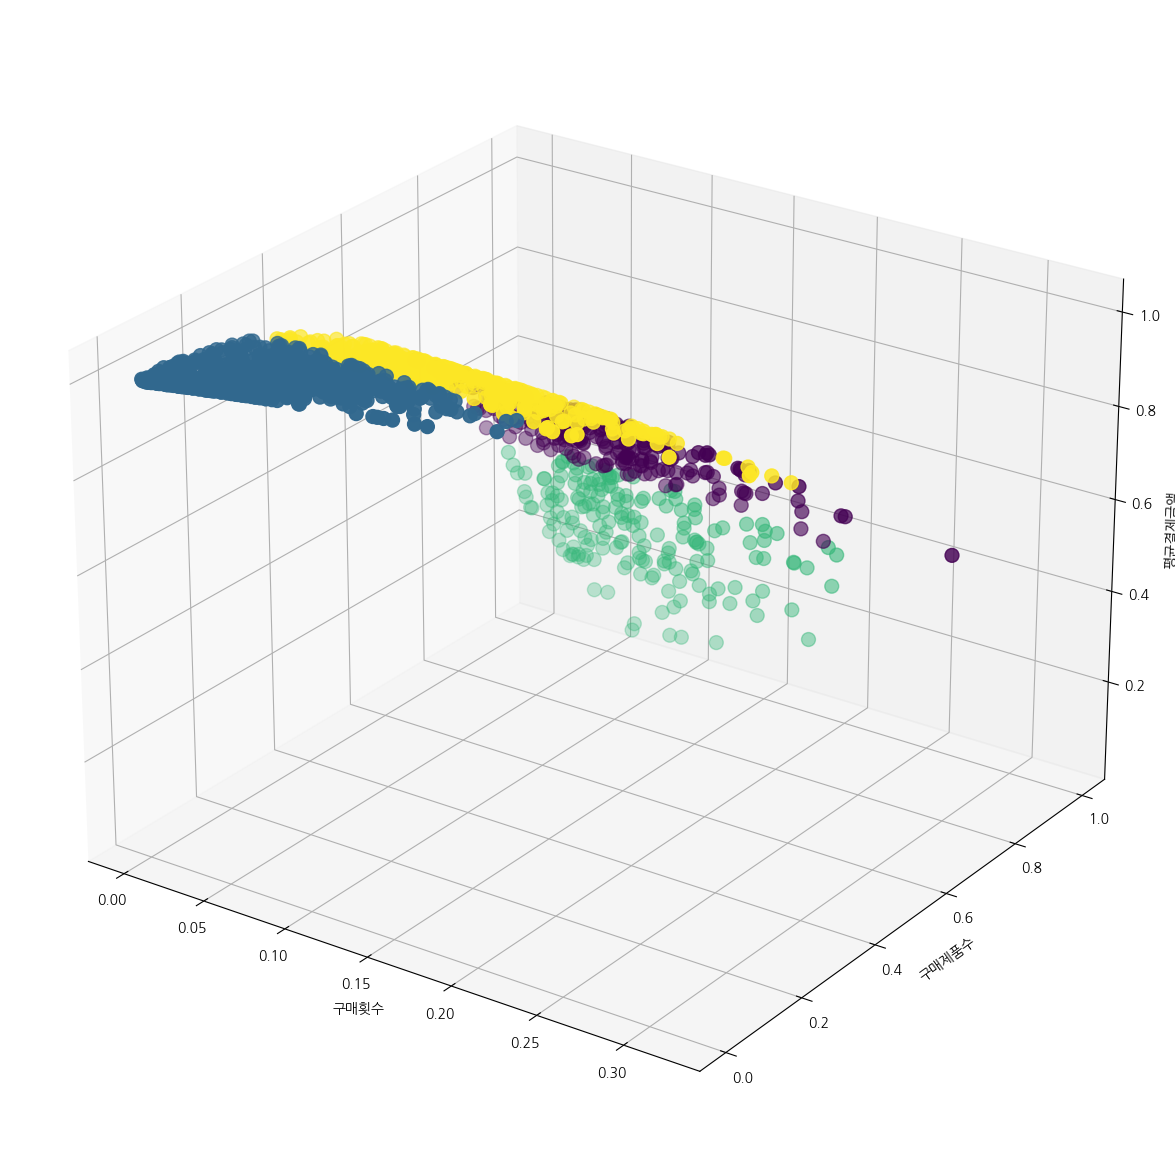

In [ ]:
total_df_normalized, kmeans_cols_df_normalized = kmeans_draw_3d_plot2(result_df, cols_df_normalized, '구매횟수', '구매제품수', '평균결제금액', 4)

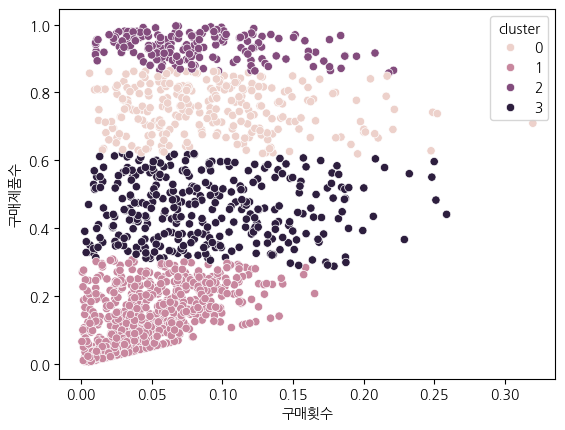

In [ ]:
drawScatterplot(total_df_normalized, '구매횟수', '구매제품수')

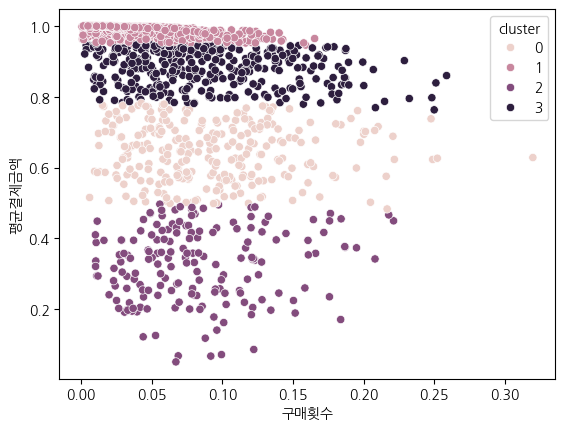

In [ ]:
drawScatterplot(total_df_normalized, '구매횟수', '평균결제금액')

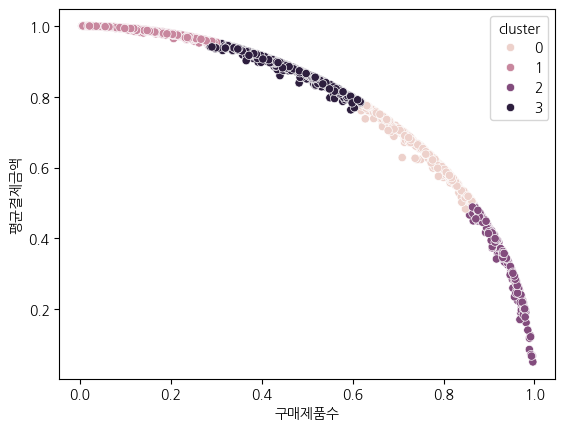

In [ ]:
drawScatterplot(total_df_normalized, '구매제품수', '평균결제금액')

- --> normalize 적용한 것이 가장 군집화가 명확하게 보임

In [ ]:
total_df_normalized_cluster = pd.concat([total_df_normalized.drop(['구매횟수', '구매제품수', '평균결제금액'], axis=1), result_df[['구매횟수', '구매제품수', '평균결제금액']]], axis=1)
total_df_normalized_cluster

,고객ID,성별,고객지역,가입기간,가입날짜,최초거래날짜,최근거래날짜,구매원가,할인가,배송료,총결제금액,평균할인차액,평균할인비율,구매제품평균금액,cluster,구매횟수,구매제품수,평균결제금액
0,USER_1358,남,Chicago,12,2019-01-01,2019-01-01,2019-01-26,38520.24,37377.56,1749.28,39126.84,-6.46,0.03,32.99,2,177,1133,221.06
1,USER_0190,남,California,43,2016-04-19,2019-01-01,2019-12-18,3360.52,3032.86,200.46,3233.32,-12.60,0.10,17.33,0,26,175,124.36
2,USER_0066,남,Chicago,33,2017-01-31,2019-01-01,2019-08-02,2671.90,2563.56,195.70,2759.26,-7.22,0.04,16.54,0,15,155,183.95
3,USER_0345,여,California,30,2017-05-23,2019-01-01,2019-01-01,1.46,1.46,6.50,7.96,0.00,0.00,1.46,1,1,1,7.96
4,USER_0683,남,California,49,2015-12-01,2019-01-01,2019-08-30,1150.17,903.36,64.38,967.74,-41.14,0.26,60.22,1,6,15,161.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_0513,여,New York,41,2016-07-05,2019-12-30,2019-12-31,559.89,491.44,31.50,522.94,-13.69,0.13,16.95,1,5,29,104.59
1464,USER_0167,여,Chicago,48,2016-01-05,2019-12-31,2019-12-31,3272.39,3150.20,103.99,3254.19,-8.73,0.04,90.01,1,14,35,232.44
1465,USER_0845,남,New Jersey,19,2018-04-17,2019-12-31,2019-12-31,810.39,803.39,19.50,822.89,-2.33,0.01,80.34,1,3,10,274.30
1466,USER_0504,여,New York,45,2016-02-02,2019-12-31,2019-12-31,1198.59,1131.15,39.00,1170.15,-11.24,0.06,102.83,1,6,11,195.02


In [ ]:
total_df_normalized_cluster[total_df_normalized_cluster['cluster'] == 0].describe()

,가입기간,구매원가,할인가,배송료,총결제금액,평균할인차액,평균할인비율,구매제품평균금액,cluster,구매횟수,구매제품수,평균결제금액
count,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.00000,272.000000,272.0,272.000000,272.000000,272.000000
mean,26.125000,4745.374228,4413.694669,226.065772,4639.760441,-13.700294,0.07375,19.897390,0.0,24.786765,226.577206,187.494081
std,13.636254,3158.309291,2958.547776,128.061533,3059.367666,11.410747,0.04321,11.343267,0.0,14.021548,118.310156,82.248709
min,2.000000,173.980000,158.650000,30.000000,196.150000,-116.320000,0.00000,2.060000,0.0,3.000000,39.000000,32.690000
25%,15.000000,2425.077500,2279.402500,129.292500,2387.725000,-17.237500,0.04000,11.150000,0.0,13.750000,153.000000,140.390000
50%,27.000000,3926.765000,3589.520000,202.120000,3842.210000,-11.495000,0.07000,17.440000,0.0,23.000000,207.500000,172.705000
75%,38.250000,6361.047500,5887.870000,300.947500,6162.517500,-7.065000,0.10000,26.967500,0.0,33.000000,266.250000,209.437500
max,50.000000,17634.020000,17193.110000,724.880000,17443.750000,0.000000,0.26000,58.150000,0.0,70.000000,1141.000000,734.730000


In [ ]:
total_df_normalized_cluster[total_df_normalized_cluster['cluster'] == 1].describe()

,가입기간,구매원가,할인가,배송료,총결제금액,평균할인차액,평균할인비율,구매제품평균금액,cluster,구매횟수,구매제품수,평균결제금액
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.0,683.000000,683.000000,683.000000
mean,25.796486,1169.456120,1092.437379,53.844129,1146.281508,-11.022738,0.068858,53.170307,1.0,6.412884,23.837482,172.222240
std,14.096687,1227.377838,1159.079043,50.721106,1192.600983,13.329507,0.069909,38.538446,0.0,5.273956,27.284183,157.110998
min,2.000000,1.100000,0.990000,6.000000,6.990000,-126.940000,0.000000,0.990000,1.0,1.000000,1.000000,6.990000
25%,14.000000,275.565000,261.800000,18.000000,291.325000,-15.025000,0.020000,22.380000,1.0,2.000000,7.000000,95.285000
50%,25.000000,827.240000,791.510000,42.000000,838.300000,-7.060000,0.050000,44.630000,1.0,5.000000,17.000000,153.440000
75%,38.000000,1619.770000,1562.995000,75.975000,1634.940000,-2.245000,0.090000,78.120000,1.0,9.000000,31.500000,207.800000
max,50.000000,8921.980000,8687.330000,427.800000,8876.030000,0.000000,0.410000,212.910000,1.0,32.000000,289.000000,1867.750000


In [ ]:
total_df_normalized_cluster[total_df_normalized_cluster['cluster'] == 2].describe()

,가입기간,구매원가,할인가,배송료,총결제금액,평균할인차액,평균할인비율,구매제품평균금액,cluster,구매횟수,구매제품수,평균결제금액
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.0,178.000000,178.000000,178.000000
mean,26.308989,11539.403764,10787.248258,522.301798,11309.550056,-14.074438,0.071348,15.379157,2.0,55.758427,721.325843,205.373427
std,12.950581,11918.141699,11239.712818,482.981570,11680.114385,8.253041,0.034842,7.775289,0.0,50.042954,613.701620,95.774418
min,2.000000,1473.250000,1297.220000,49.990000,1391.700000,-54.950000,0.020000,2.420000,2.0,7.000000,200.000000,82.380000
25%,16.000000,5034.915000,4643.272500,258.215000,4868.510000,-17.590000,0.050000,9.682500,2.0,28.000000,401.000000,164.750000
50%,28.000000,8211.135000,7881.815000,422.115000,8285.265000,-12.255000,0.060000,13.775000,2.0,42.000000,538.000000,185.515000
75%,36.750000,12744.585000,11934.837500,591.982500,12461.890000,-8.425000,0.090000,19.710000,2.0,65.000000,800.500000,213.012500
max,49.000000,85311.250000,82073.950000,3715.320000,84405.830000,-2.710000,0.180000,40.820000,2.0,328.000000,4869.000000,971.390000


In [ ]:
total_df_normalized_cluster[total_df_normalized_cluster['cluster'] == 3].describe()

,가입기간,구매원가,할인가,배송료,총결제금액,평균할인차액,평균할인비율,구매제품평균금액,cluster,구매횟수,구매제품수,평균결제금액
count,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.0,335.000000,335.000000,335.000000
mean,25.764179,3110.008478,2907.303493,142.544627,3049.848119,-12.024687,0.069881,31.452925,3.0,16.668657,94.707463,179.702119
std,14.499470,2525.862960,2362.731886,97.072031,2438.885188,9.427968,0.051493,22.100502,0.0,11.088676,49.137450,77.043404
min,2.000000,18.760000,15.950000,6.000000,28.430000,-70.450000,0.000000,1.530000,3.0,1.000000,10.000000,27.180000
25%,12.500000,1264.960000,1194.320000,73.130000,1257.740000,-16.765000,0.030000,15.170000,3.0,8.000000,61.000000,131.720000
50%,26.000000,2542.650000,2394.250000,126.410000,2522.790000,-9.800000,0.060000,26.200000,3.0,14.000000,88.000000,173.320000
75%,38.500000,4167.905000,3975.015000,192.205000,4161.020000,-5.460000,0.095000,42.740000,3.0,23.000000,116.500000,212.435000
max,50.000000,19323.830000,18006.380000,720.040000,18570.500000,0.000000,0.400000,119.980000,3.0,78.000000,373.000000,622.060000


# 2. DBScan

## 2-1. 스케일러 미적용

- https://rfriend.tistory.com/588
- https://www.sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/

In [ ]:
result_df[['구매횟수', '구매제품수', '평균결제금액']].describe()

,구매횟수,구매제품수,평균결제금액
count,1468.000000,1468.000000,1468.000000
mean,18.141008,162.147820,180.778515
std,24.976414,312.374078,123.690403
min,1.000000,1.000000,6.990000
25%,5.000000,19.000000,124.952500
50%,11.000000,61.000000,168.340000
75%,23.000000,178.000000,210.135000
max,328.000000,4869.000000,1867.750000


In [24]:
from sklearn.cluster import DBSCAN

def dbscan_clustering(df, num1, num2):

  feature = df[['구매횟수', '구매제품수', '평균결제금액']]

  model = DBSCAN(eps = num1, min_samples=num2)
  predict = pd.DataFrame(model.fit_predict(feature))
  predict.columns=['predict']

  dbscan_df = pd.concat([result_df.drop(['구매횟수', '구매제품수', '평균결제금액'], axis=1), predict], axis=1)

  print(dbscan_df.groupby(['predict'])['고객ID'].count().reset_index())

  return dbscan_df

- eps 및 min_samples 지정
  - min_samples : 보통 2차원 이상에서는 2 * dim 으로 지정

Best parameters: {'eps': 51.111111111111114, 'min_samples': 5}


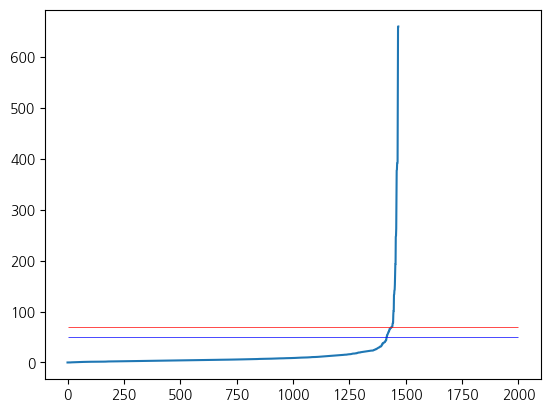

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics

# Nearest Neighbors 모델 초기화 및 학습
nn_model = NearestNeighbors(n_neighbors=2)
nn_model.fit(result_df[['구매횟수', '구매제품수', '평균결제금액']])
distances, indices = nn_model.kneighbors(result_df[['구매횟수', '구매제품수', '평균결제금액']])

# k-distance 그래프 생성
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.hlines(50, 0, 2000, color='blue', linestyle='-', linewidth=0.5)
plt.hlines(70, 0, 2000, color='red', linestyle='-', linewidth=0.5)

# DBSCAN 파라미터 튜닝
eps_values = np.linspace(50, 60, 10)  # eps 후보 값 범위
min_samples_values = range(2, 6)  # min_samples 후보 값 범위
best_score = -1
best_params = {'eps': None, 'min_samples': None}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(result_df[['구매횟수', '구매제품수', '평균결제금액']])
        labels = dbscan.labels_
        n_clusters = len(np.unique(labels))
        if n_clusters > 1:
            score = metrics.silhouette_score(result_df[['구매횟수', '구매제품수', '평균결제금액']], labels)
            if score > best_score:
                best_score = score
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples

print("Best parameters:", best_params)

In [21]:
dbscan_df_ = dbscan_clustering(result_df, 51.111111111111114, 5)

   predict  고객ID
0       -1    73
1        0  1371
2        1     6
3        2    18


## 2-2. 스케일러 적용

- standard

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols_standard = scaler.fit_transform(result_df[['구매횟수', '구매제품수', '평균결제금액']])
cols_df_standard = pd.DataFrame(cols_standard, columns = ['구매횟수', '구매제품수', '평균결제금액'])

Best parameters: {'eps': 1.0, 'min_samples': 3}


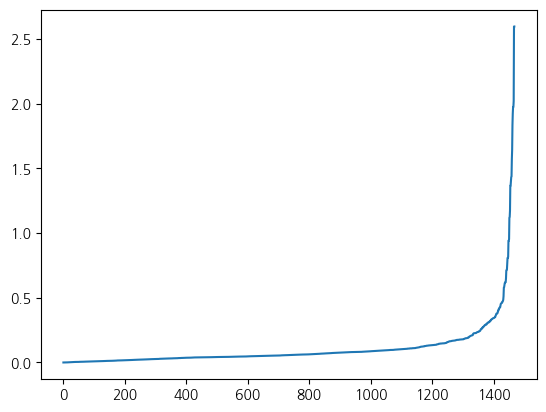

In [36]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics

# Nearest Neighbors 모델 초기화 및 학습
nn_model = NearestNeighbors(n_neighbors=2)
nn_model.fit(cols_df_standard)
distances, indices = nn_model.kneighbors(cols_df_standard)

# k-distance 그래프 생성
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
#plt.hlines(50, 0, 2000, color='blue', linestyle='-', linewidth=0.5)
#plt.hlines(70, 0, 2000, color='red', linestyle='-', linewidth=0.5)

# DBSCAN 파라미터 튜닝
eps_values = np.linspace(0.1, 1.0, 10)  # eps 후보 값 범위
min_samples_values = range(2, 6)  # min_samples 후보 값 범위
best_score = -1
best_params = {'eps': None, 'min_samples': None}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(cols_df_standard)
        labels = dbscan.labels_
        n_clusters = len(np.unique(labels))
        if n_clusters > 1:
            score = metrics.silhouette_score(cols_df_standard, labels)
            if score > best_score:
                best_score = score
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples

print("Best parameters:", best_params)

In [30]:
dbscan_df_standard = dbscan_clustering(cols_df_minmax, 1.0, 3)

   predict  고객ID
0        0  1468


- minmax

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols_minmax = scaler.fit_transform(result_df[['구매횟수', '구매제품수', '평균결제금액']])
cols_df_minmax = pd.DataFrame(cols_minmax, columns = ['구매횟수', '구매제품수', '평균결제금액'])

Best parameters: {'eps': 0.4, 'min_samples': 5}


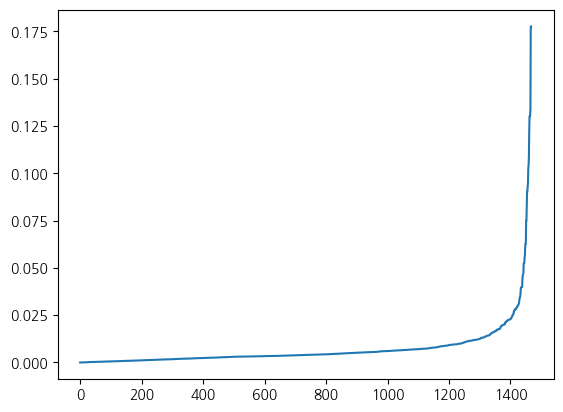

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics

# Nearest Neighbors 모델 초기화 및 학습
nn_model = NearestNeighbors(n_neighbors=2)
nn_model.fit(cols_df_minmax)
distances, indices = nn_model.kneighbors(cols_df_minmax)

# k-distance 그래프 생성
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
#plt.hlines(50, 0, 2000, color='blue', linestyle='-', linewidth=0.5)
#plt.hlines(70, 0, 2000, color='red', linestyle='-', linewidth=0.5)

# DBSCAN 파라미터 튜닝
eps_values = np.linspace(0.1, 1.00, 10)  # eps 후보 값 범위
min_samples_values = range(2, 6)  # min_samples 후보 값 범위
best_score = -1
best_params = {'eps': None, 'min_samples': None}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(cols_df_minmax)
        labels = dbscan.labels_
        n_clusters = len(np.unique(labels))
        if n_clusters > 1:
            score = metrics.silhouette_score(cols_df_minmax, labels)
            if score > best_score:
                best_score = score
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples

print("Best parameters:", best_params)

In [27]:
dbscan_df_minmax = dbscan_clustering(cols_df_minmax, 0.4, 5)

   predict  고객ID
0        0  1464
1        1     4


- normalize

In [31]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer()
cols_normalized = scaler.fit_transform(result_df[['구매횟수', '구매제품수', '평균결제금액']])
cols_df_normalized = pd.DataFrame(cols_normalized, columns = ['구매횟수', '구매제품수', '평균결제금액'])

Best parameters: {'eps': None, 'min_samples': None}


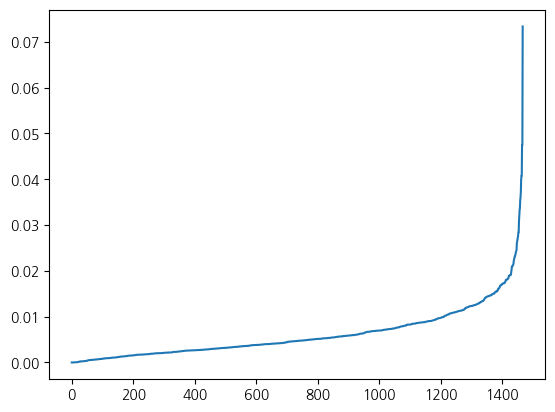

In [33]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics

# Nearest Neighbors 모델 초기화 및 학습
nn_model = NearestNeighbors(n_neighbors=2)
nn_model.fit(cols_df_normalized)
distances, indices = nn_model.kneighbors(cols_df_normalized)

# k-distance 그래프 생성
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
#plt.hlines(50, 0, 2000, color='blue', linestyle='-', linewidth=0.5)
#plt.hlines(70, 0, 2000, color='red', linestyle='-', linewidth=0.5)

# DBSCAN 파라미터 튜닝
eps_values = np.linspace(0.1, 1.0, 100)  # eps 후보 값 범위
min_samples_values = range(2, 6)  # min_samples 후보 값 범위
best_score = -1
best_params = {'eps': None, 'min_samples': None}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(cols_df_normalized)
        labels = dbscan.labels_
        n_clusters = len(np.unique(labels))
        if n_clusters > 1:
            score = metrics.silhouette_score(cols_df_normalized, labels)
            if score > best_score:
                best_score = score
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples

print("Best parameters:", best_params)

- --> scaler 적용해도 dbscan으로는 의미있는 군집화를 하기가 어려움